In [1]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import Final Dataset

In [2]:
df = pd.read_csv('process_csv_stage_3.csv')
df

,old_index,preprocessed_text,topic_lda,priority
0,1,good morning name appreciate could help put st...,0,3
1,2,upgraded card tell agent upgrade anniversary d...,3,1
2,10,chase card report however fraudulent applicati...,6,2
3,11,try book ticket come across offer apply toward...,3,3
4,14,grand son give check deposit chase account fun...,4,3
...,...,...,...,...
21067,78303,chase card customer well decade offer multiple...,3,3
21068,78309,wednesday call chas visa credit card provider ...,8,1
21069,78310,familiar pay understand great risk provide con...,2,2
21070,78311,flawless credit chase credit card chase freedo...,7,3


# TF-IDF text representation

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df['preprocessed_text']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(21072, 16306)

In [4]:
vectorizer.get_feature_names_out()

array(['aad', 'aba', 'abandon', ..., 'zoom', 'zur', 'zyk'], dtype=object)

# Data Partition

In [5]:
# split into training set and validation set
from sklearn.model_selection import train_test_split

y = df[['topic_lda','priority']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 16306)
(4215, 16306)
(16857, 2)
(4215, 2)


# Model Building

In [7]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

svc = MultiOutputClassifier(LinearSVC(random_state=42)).fit(X_train, y_train)
svc.score(X_test,y_test)

C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.637485172004745

In [8]:
svc.predict(X_test)

array([[0, 2],
       [0, 3],
       [1, 1],
       ...,
       [3, 3],
       [6, 3],
       [1, 3]], dtype=int64)

In [9]:
svc.predict(X_test)[:, 0]

array([0, 0, 1, ..., 3, 6, 1], dtype=int64)

In [10]:
svc.predict(X_test)[:, 1]

array([2, 3, 1, ..., 3, 3, 3], dtype=int64)

# Evaluation

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [12]:
svc_preds = svc.predict(X_test)

================ Ticket Category =================
Accuracy:  0.8661921708185053
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       857
           1       0.90      0.94      0.92       463
           2       0.86      0.69      0.76       200
           3       0.87      0.90      0.89       393
           4       0.87      0.88      0.87       628
           5       0.82      0.83      0.82       281
           6       0.88      0.91      0.89       508
           7       0.86      0.85      0.86       474
           8       0.86      0.81      0.84       411

    accuracy                           0.87      4215
   macro avg       0.86      0.85      0.86      4215
weighted avg       0.87      0.87      0.87      4215



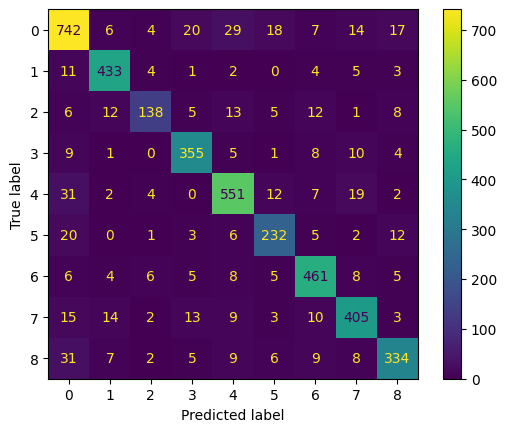

In [13]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=svc_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], svc_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=svc_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.7345195729537367
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.68      0.69       802
           2       0.62      0.51      0.56      1282
           3       0.80      0.89      0.84      2131

    accuracy                           0.73      4215
   macro avg       0.70      0.69      0.70      4215
weighted avg       0.72      0.73      0.73      4215



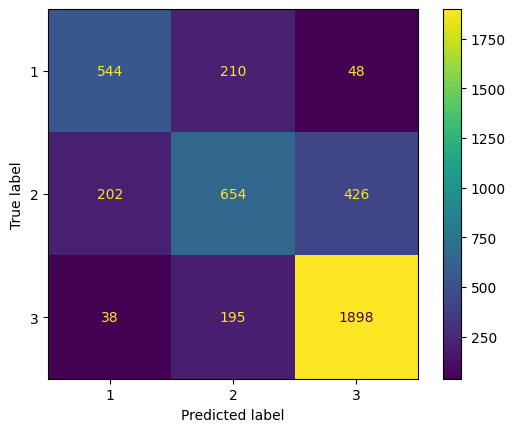

In [14]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=svc_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], svc_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=svc_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {
    'estimator__C': [0.05, 0.1, 0.5, 1, 1.5, 2.5, 5, 10, 50],  # Regularization strength parameter
    'estimator__multi_class': ['ovr','crammer_singer'] # multi-class strategy
}

In [17]:
grid_search = GridSearchCV(
    estimator=MultiOutputClassifier(LinearSVC(random_state=42)), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dxlee\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=LinearSVC(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.05, 0.1, 0.5, 1, 1.5, 2.5, 5, 10,
                                          50],
                         'estimator__multi_class': ['ovr', 'crammer_singer']},
             verbose=2)

In [19]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'estimator__C': 1.5, 'estimator__multi_class': 'crammer_singer'}


In [20]:
bestsvc = grid_search.best_estimator_

In [21]:
best_svc_score = bestsvc.score(X_test, y_test)
print("Best model accuracy:", best_svc_score)

Best model accuracy: 0.6467378410438909


# Evaluation After Tuning

In [22]:
bestsvc_preds = bestsvc.predict(X_test)

================ Ticket Category =================
Accuracy:  0.8749703440094899
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87       857
           1       0.92      0.94      0.93       463
           2       0.82      0.76      0.79       200
           3       0.88      0.91      0.89       393
           4       0.89      0.88      0.89       628
           5       0.83      0.84      0.83       281
           6       0.88      0.90      0.89       508
           7       0.86      0.86      0.86       474
           8       0.88      0.83      0.86       411

    accuracy                           0.87      4215
   macro avg       0.87      0.86      0.87      4215
weighted avg       0.87      0.87      0.87      4215



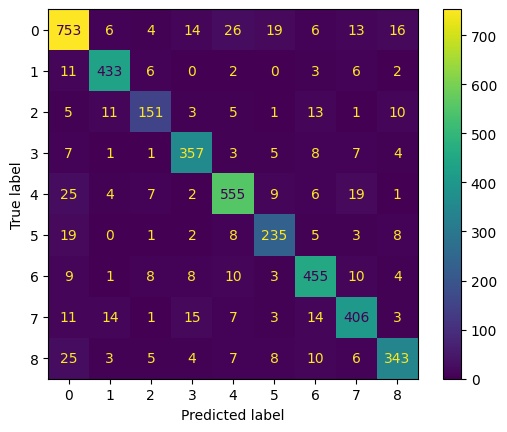

In [23]:
print(f'{" Ticket Category ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['topic_lda'], y_pred=bestsvc_preds[:, 0]))
print("Classification Report:\n",classification_report(y_test['topic_lda'], bestsvc_preds[:, 0]))

cm = confusion_matrix(y_true=y_test['topic_lda'], y_pred=bestsvc_preds[:, 0])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(9)])
cm_display.plot()
plt.show()

================ Ticket Priority =================
Accuracy:  0.7399762752075919
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.72      0.70       802
           2       0.62      0.53      0.57      1282
           3       0.82      0.87      0.84      2131

    accuracy                           0.74      4215
   macro avg       0.71      0.71      0.71      4215
weighted avg       0.73      0.74      0.73      4215



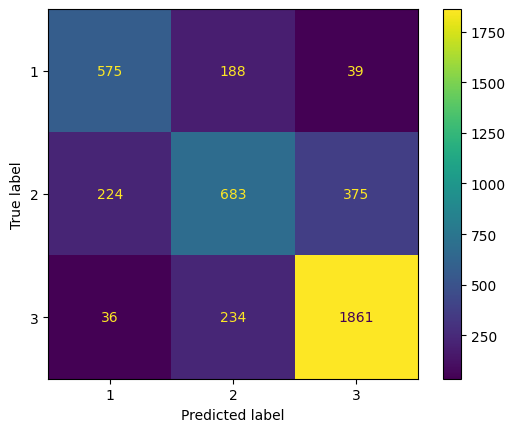

In [24]:
print(f'{" Ticket Priority ":=^50}')
print("Accuracy: ", accuracy_score(y_true=y_test['priority'], y_pred=bestsvc_preds[:, 1]))
print("Classification Report:\n",classification_report(y_test['priority'], bestsvc_preds[:, 1]))

cm = confusion_matrix(y_true=y_test['priority'], y_pred=bestsvc_preds[:, 1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [i for i in range(1,4)])
cm_display.plot()
plt.show()

# Save tuned model to disk

In [25]:
import os
from pickle import dump
with open(os.path.join(os.getcwd(),'ml_models',"tuned_svc.pkl"), "wb") as f:
    dump(bestsvc, f, protocol=5)